In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, MobileNet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [ ]:
from zipfile import ZipFile
with ZipFile('/content/Flowers_Dataset.zip', 'r') as zip:
    zip.extractall()

In [ ]:
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('/content/Flowers_Dataset/train', target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = test_datagen.flow_from_directory('/content/Flowers_Dataset/test', target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

Found 2920 images belonging to 5 classes.
Found 730 images belonging to 5 classes.


## Ensemble Technique on pre-trained model

In [ ]:
def create_model(base_model):
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
vgg16_model = create_model(VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3)))
vgg19_model = create_model(VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3)))
resnet50_model = create_model(ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3)))
mobilenet_model = create_model(MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3)))

94765736/94765736 [==============================] - 3s 0us/step


17225924/17225924 [==============================] - 1s 0us/step


In [ ]:
history_vgg16 = vgg16_model.fit(train_generator, epochs=10, validation_data=test_generator)
history_vgg19 = vgg19_model.fit(train_generator, epochs=10, validation_data=test_generator)
history_resnet50 = resnet50_model.fit(train_generator, epochs=10, validation_data=test_generator)
history_mobilenet = mobilenet_model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
92/92 [==============================] - 53s 362ms/step - loss: 1.7611 - accuracy: 0.2168 - val_loss: 1.6572 - val_accuracy: 0.2000
Epoch 2/10
92/92 [==============================] - 33s 358ms/step - loss: 1.4464 - accuracy: 0.3401 - val_loss: 1.2708 - val_accuracy: 0.4000
Epoch 3/10
92/92 [==============================] - 30s 323ms/step - loss: 1.2491 - accuracy: 0.4517 - val_loss: 1.2427 - val_accuracy: 0.4795
Epoch 4/10
92/92 [==============================] - 28s 304ms/step - loss: 1.1801 - accuracy: 0.4791 - val_loss: 1.2161 - val_accuracy: 0.5096
Epoch 5/10
92/92 [==============================] - 31s 330ms/step - loss: 1.1516 - accuracy: 0.5151 - val_loss: 1.1178 - val_accuracy: 0.5479
Epoch 6/10
92/92 [==============================] - 30s 321ms/step - loss: 1.1125 - accuracy: 0.5476 - val_loss: 1.1206 - val_accuracy: 0.5411
Epoch 7/10
92/92 [==============================] - 29s 311ms/step - loss: 1.1110 - accuracy: 0.5479 - val_loss: 1.2381 - val_accuracy: 0.4890

In [ ]:
def plot_history(history, model_name):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='test_accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Training and Testing Accuracy')
    plt.legend()
    plt.show()

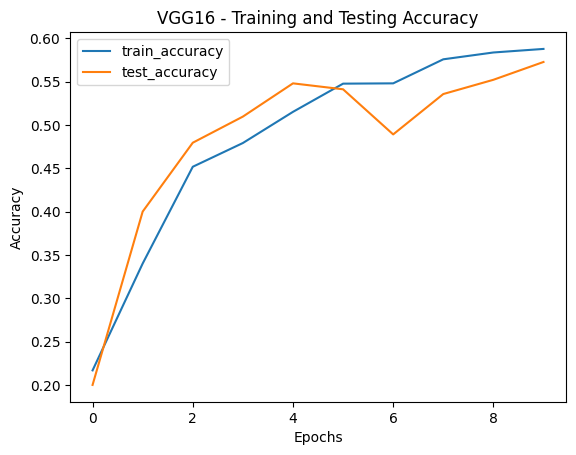

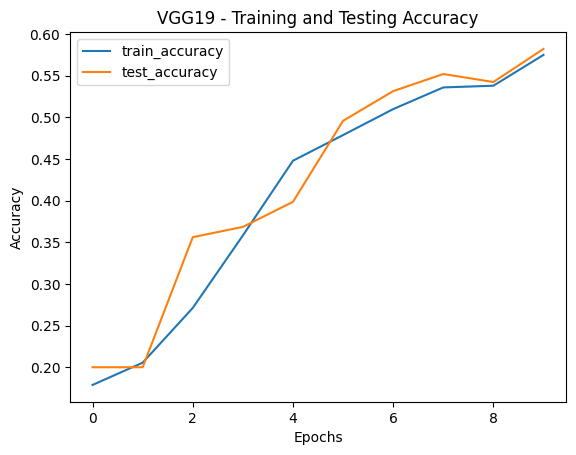

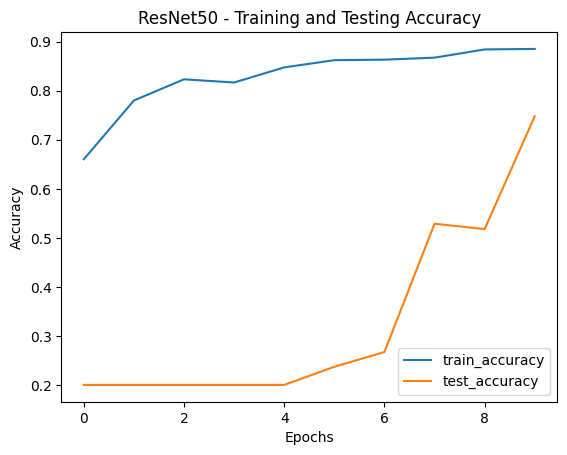

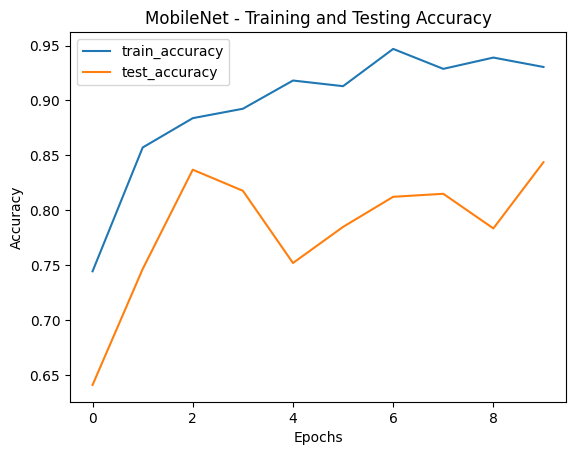

In [ ]:
plot_history(history_vgg16, 'VGG16')
plot_history(history_vgg19, 'VGG19')
plot_history(history_resnet50, 'ResNet50')
plot_history(history_mobilenet, 'MobileNet')

In [ ]:
def ensemble(models, model_input):
    outputs = [model(model_input) for model in models]
    avg = tf.keras.layers.average(outputs)
    model = Model(inputs=model_input, outputs=avg, name='ensemble')
    return model

In [ ]:
model_input = tf.keras.Input(shape=(150, 150, 3))
models = [vgg16_model, vgg19_model, resnet50_model, mobilenet_model]

ensemble_model = ensemble(models, model_input)

In [ ]:
ensemble_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_ensemble = ensemble_model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
92/92 [==============================] - 136s 793ms/step - loss: 0.5691 - accuracy: 0.8370 - val_loss: 1.1218 - val_accuracy: 0.6274
Epoch 2/10
92/92 [==============================] - 70s 757ms/step - loss: 0.6674 - accuracy: 0.8281 - val_loss: 1.0533 - val_accuracy: 0.5521
Epoch 3/10
92/92 [==============================] - 70s 755ms/step - loss: 0.6584 - accuracy: 0.8130 - val_loss: 0.9552 - val_accuracy: 0.7055
Epoch 4/10
92/92 [==============================] - 70s 760ms/step - loss: 0.7757 - accuracy: 0.7538 - val_loss: 1.0512 - val_accuracy: 0.6123
Epoch 5/10
92/92 [==============================] - 70s 758ms/step - loss: 0.7961 - accuracy: 0.7579 - val_loss: 0.9913 - val_accuracy: 0.6000
Epoch 6/10
92/92 [==============================] - 69s 748ms/step - loss: 0.7438 - accuracy: 0.7887 - val_loss: 0.8126 - val_accuracy: 0.7329
Epoch 7/10
92/92 [==============================] - 69s 748ms/step - loss: 0.7413 - accuracy: 0.8024 - val_loss: 0.9862 - val_accuracy: 0.695

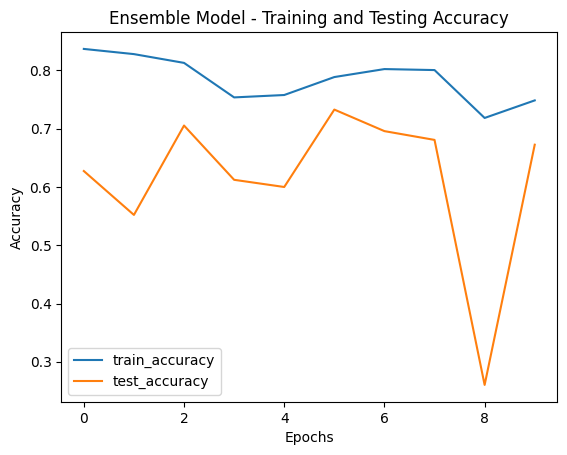

In [ ]:
plot_history(history_ensemble, 'Ensemble Model')

## Fine Tuning Pre-Trained model

In [ ]:
def fine_tune_model(base_model, unfreeze_from=15):
    for layer in base_model.layers[:unfreeze_from]:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
vgg16_fine_tuned = fine_tune_model(VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3)))
vgg19_fine_tuned = fine_tune_model(VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3)))
resnet50_fine_tuned = fine_tune_model(ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3)))
mobilenet_fine_tuned = fine_tune_model(MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3)))

In [ ]:
fine_tuned_models = [vgg16_fine_tuned, vgg19_fine_tuned, resnet50_fine_tuned, mobilenet_fine_tuned]
ensemble_model_fine_tuned = ensemble(fine_tuned_models, model_input)

In [ ]:
ensemble_model_fine_tuned.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_ensemble_fine_tuned = ensemble_model_fine_tuned.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
92/92 [==============================] - 93s 508ms/step - loss: 1.2848 - accuracy: 0.5784 - val_loss: 2.3385 - val_accuracy: 0.2000
Epoch 2/10
92/92 [==============================] - 49s 528ms/step - loss: 1.1845 - accuracy: 0.5825 - val_loss: 1.3428 - val_accuracy: 0.3479
Epoch 3/10
92/92 [==============================] - 44s 479ms/step - loss: 1.0981 - accuracy: 0.6695 - val_loss: 4.2200 - val_accuracy: 0.2411
Epoch 4/10
92/92 [==============================] - 44s 472ms/step - loss: 1.1439 - accuracy: 0.6777 - val_loss: 2.1477 - val_accuracy: 0.4986
Epoch 5/10
92/92 [==============================] - 44s 475ms/step - loss: 1.0917 - accuracy: 0.6959 - val_loss: 1.7720 - val_accuracy: 0.4301
Epoch 6/10
92/92 [==============================] - 44s 474ms/step - loss: 1.0091 - accuracy: 0.7349 - val_loss: 1.4858 - val_accuracy: 0.2932
Epoch 7/10
92/92 [==============================] - 44s 474ms/step - loss: 1.0030 - accuracy: 0.7373 - val_loss: 1.3400 - val_accuracy: 0.6630

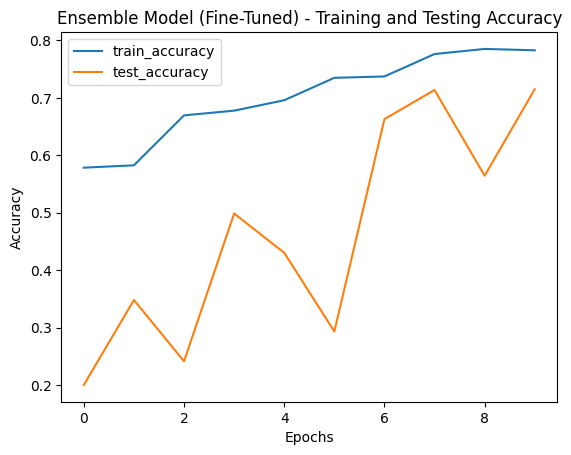

In [ ]:
plot_history(history_ensemble_fine_tuned, 'Ensemble Model (Fine-Tuned)')